# Toy: AR1 model

Note, you can find the original version of this notebook at [https://github.com/mackelab/sbi/blob/main/tutorials/02_flexible_interface.ipynb](https://github.com/mackelab/sbi/blob/main/tutorials/02_flexible_interface.ipynb) in the `sbi` repository.

## Main syntax

```Python
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi

simulator, prior = prepare_for_sbi(simulator, prior)
inference = SNPE(prior)

theta, x = simulate_for_sbi(simulator, proposal=prior, num_simulations=1000)
density_estimator = inference.append_simulations(theta, x).train()
posterior = inference.build_posterior(density_estimator)
```

In [1]:
import torch
import numpy as np

from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi.utils.get_nn_models import posterior_nn
from sbi import utils as utils
from sbi import analysis as analysis

Next, we define the prior and simulator:

In [2]:
num_dim = 2
prior = utils.BoxUniform(low=[4.2,0.005], high=[5.8,0.025])

In [3]:
def generate_ar1_time_series(theta):
    time_series = np.zeros(length)
    time_series[0] = x_0
    for t in range(1, length):
        noise = np.random.normal(0, theta[1])
        time_series[t] =  theta[0] * time_series[t - 1]**2 * (1-time_series[t - 1]) + noise
    return time_series

In the flexible interface, you have to ensure that your simulator and prior adhere the requirements of `sbi`. You can do so with the `prepare_for_sbi()` function.

In [8]:
length = 200
x_0 = 0.25
simulator, prior = prepare_for_sbi(generate_ar1_time_series, prior)

Then, we instantiate the inference object:

In [9]:
inference = SNPE(prior=prior)

Next, we run simulations. You can do so either by yourself by sampling from the prior and running the simulator (e.g. on a compute cluster), or you can use a helper function provided by `sbi` called `simulate_for_sbi`. This function allows to parallelize your code with `joblib`.

In [10]:
theta, x = simulate_for_sbi(simulator, proposal=prior, num_simulations=2000)

Running 2000 simulations.:   0%|          | 0/2000 [00:00<?, ?it/s]

We then pass the simulated data to the inference object. `theta` and `x` should both be a `torch.Tensor` of type `float32`.

In [13]:
theta

tensor([[5.3841e+00, 2.4341e-02],
        [5.7249e+00, 1.3959e-02],
        [5.0224e+00, 5.3691e-03],
        ...,
        [4.6981e+00, 2.1320e-02],
        [4.6109e+00, 1.0282e-02],
        [4.3102e+00, 2.2207e-02]])

In [8]:
inference = inference.append_simulations(theta, x)

Next, we train the neural density estimator.

In [9]:
density_estimator = inference.train()

 Neural network successfully converged after 59 epochs.

Lastly, we can use this density estimator to build the posterior:

In [10]:
posterior = inference.build_posterior(density_estimator)

Once we have obtained the posterior, we can `.sample()`, `.log_prob()`, or `.pairplot()` in the same way as for the simple interface.

In [11]:
# Example usage:
c = 4.5
noise_std = 0.01  # Standard deviation of the additive noise

x_o = generate_ar1_time_series([c, noise_std])

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

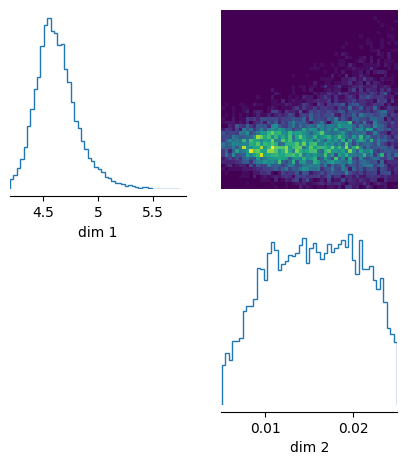

In [12]:
posterior_samples = posterior.sample((10000,), x=x_o)

# plot posterior samples
_ = analysis.pairplot(
    posterior_samples, limits=[[4.2, 5.8], [0.005, 0.025]], figsize=(5, 5)
)

We can always print the posterior to know how it was trained:

In [51]:
print(posterior)

Posterior conditional density p(θ|x) of type DirectPosterior. It samples the posterior network and rejects samples that
            lie outside of the prior bounds.
